In [ ]:
import sys
import random
import operator
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import preprocessing, metrics, ensemble, linear_model, tree, model_selection
import matplotlib.pyplot as plt


%matplotlib inline

In [25]:
train_df = pd.read_csv('dataset/yds_train2018.csv')
test_df = pd.read_csv('dataset/yds_test2018.csv')
promotional_expense = pd.read_csv('dataset/promotional_expense.csv')
holidays = pd.read_excel('dataset/holidays.xlsx')
sample_submission = pd.read_csv('dataset/sample_submission.csv')

In [26]:
print('Shape of train_df: ', train_df.shape)
print('Shape of test_df: ', test_df.shape)

Shape of train_df:  (79072, 8)
Shape of test_df:  (105, 6)


In [27]:
train_df1 = train_df.groupby(['Year', 'Month', 'Product_ID', 'Country'])['Sales'].sum()
train_df1 = train_df1.reset_index()

In [28]:
holidays['Month'] = holidays.Date.apply(lambda x: str(x)[6:7])
holidays['Year'] = holidays.Date.apply(lambda x: str(x)[0:4])

holidays['isHoliday'] = 1
holidays1 = holidays.groupby(['Country', 'Month', 'Year'])['isHoliday'].sum()
holidays1 = holidays1.reset_index()

In [29]:
holidays1.Month = holidays1.Month.astype('int64')
holidays1.Year = holidays1.Year.astype('int64')

In [30]:
train_df1 = train_df1.merge(holidays1, on=['Country', 'Month', 'Year'], how='left')
test_df1 = test_df.merge(holidays1, on=['Country', 'Month', 'Year'], how='left')

In [31]:
train_df1.isHoliday = train_df1.isHoliday.fillna(0)
test_df1.isHoliday = test_df1.isHoliday.fillna(0)

In [32]:
test_df1.drop(['Sales'], 1, inplace=True)

In [33]:
promotional_expense.columns = ['Year', 'Month', 'Country', 'Product_ID', 'Expense']
train_df1 = train_df1.merge(promotional_expense, on=['Year', 'Month', 'Country', 'Product_ID'], how='left')
test_df1 = test_df1.merge(promotional_expense, on=['Year', 'Month', 'Country', 'Product_ID'], how='left')

In [34]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)) / ((np.abs(y_true)+np.abs(y_pred))/2)) * 100

In [35]:
train_df2 = train_df1.copy()
test_df2 = test_df1.copy()

In [36]:
days = {
    1: 31,
    2: 28,
    3: 31,
    4: 30,
    5: 31,
    6: 30,
    7: 31,
    8: 31,
    9: 30,
    10: 31,
    11: 30,
    12: 31
}

In [37]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,feat))
    outfile.close()

def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, feature_names=None, seed_val=0, rounds=300, dep=7, eta=0.1):
    params = {}
    params["objective"] = "reg:linear"
    params['eval_metric'] = 'mae'
    params["eta"] = eta
    params["subsample"] = 0.8
    params["min_child_weight"] = 1
    params["colsample_bytree"] = 1
    params["max_depth"] = dep

    params["silent"] = 1
    params["seed"] = seed_val
    num_rounds = rounds

    plst = list(params.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=100, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    if feature_names is not None:
        create_feature_map(feature_names)
        model.dump_model('xgbmodel.txt', 'xgb.fmap', with_stats=True)
        importance = model.get_fscore(fmap='xgb.fmap')
        importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
        imp_df = pd.DataFrame(importance, columns=['feature','fscore'])
        imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()
        imp_df.to_csv("imp_feat.txt", index=False)

    pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    pred_train_y = model.predict( xgb.DMatrix(train_X), ntree_limit=model.best_ntree_limit)


    loss = 0
    loss = symmetric_mean_absolute_percentage_error(train_y, pred_train_y)
    if test_y is not None:
        loss = symmetric_mean_absolute_percentage_error(test_y, pred_test_y)
        return pred_test_y, loss, model, plst
    else:
        return pred_test_y, loss, model, plst

Argentina   1
4.085399348407029e-05
Argentina   2
3.2401532941891204e-05
Argentina   3
0.00016502461637362203
Columbia   1
3.4695367426078406e-05
Columbia   2
3.733371848883503e-05
Columbia   3
8.262423201223356e-05
Belgium   2
4.175111312908279e-05
Denmark   2
3.567188346809582e-05
England   4
4.128516840070891e-05
England   5
4.072700449867074e-05
Finland   4
3.750335963939696e-05


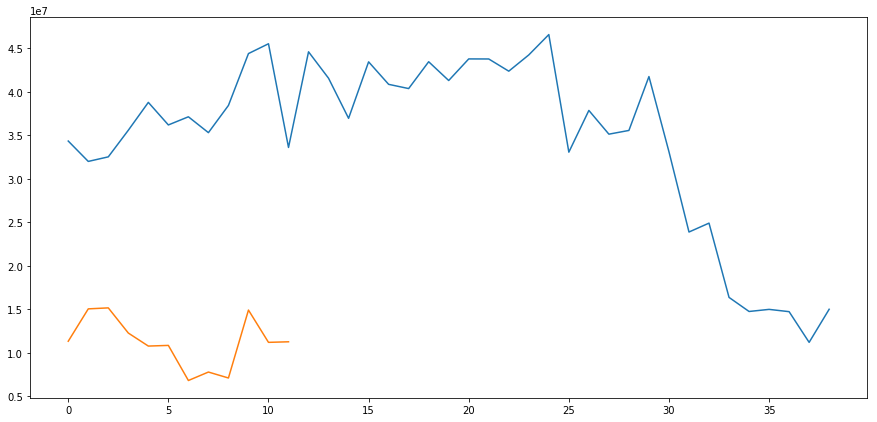

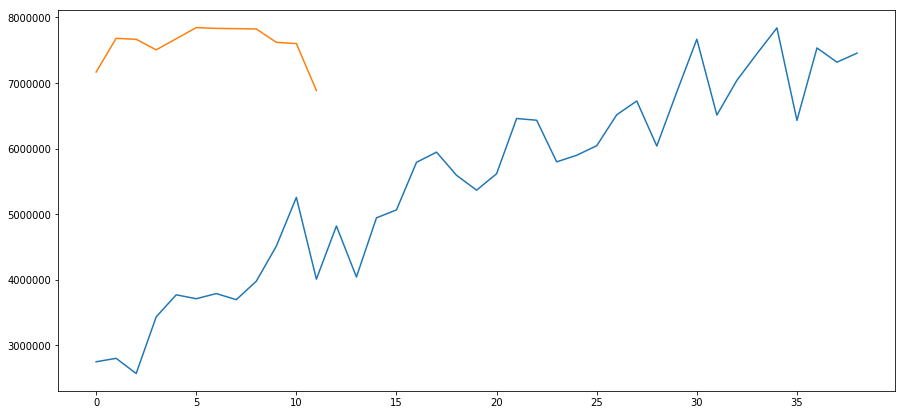

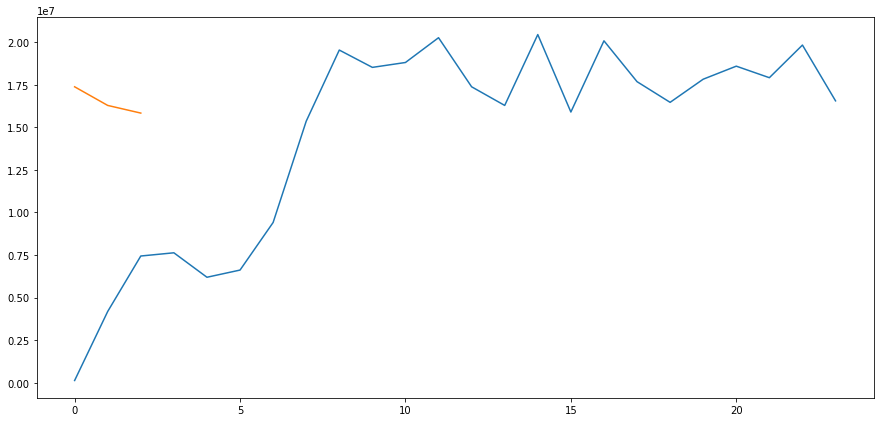

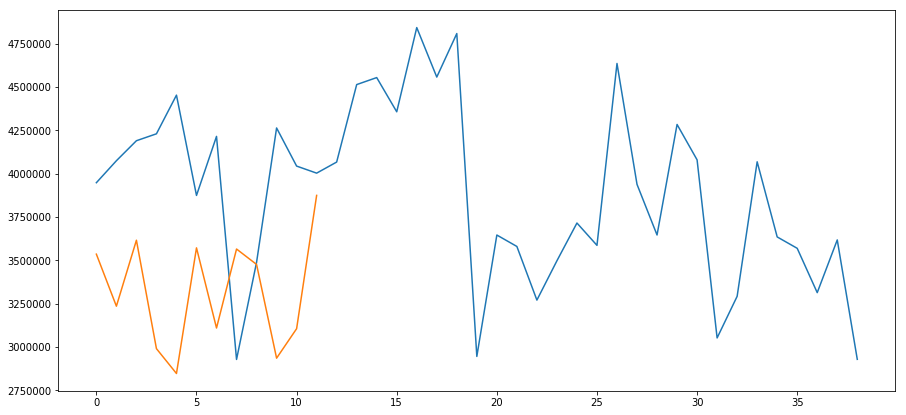

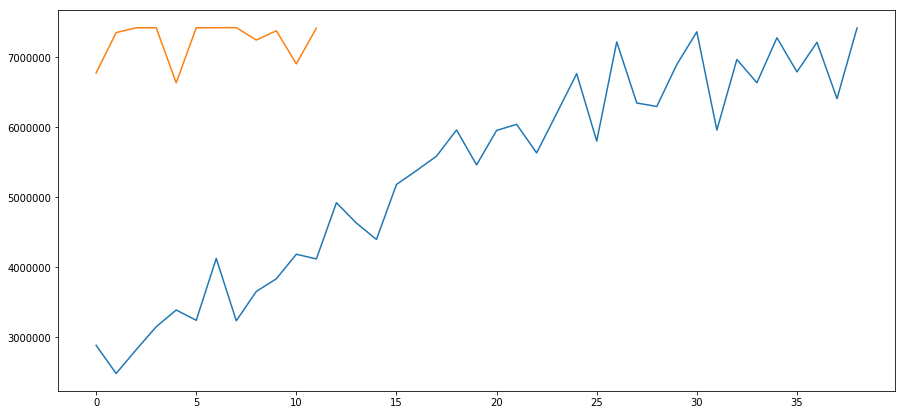

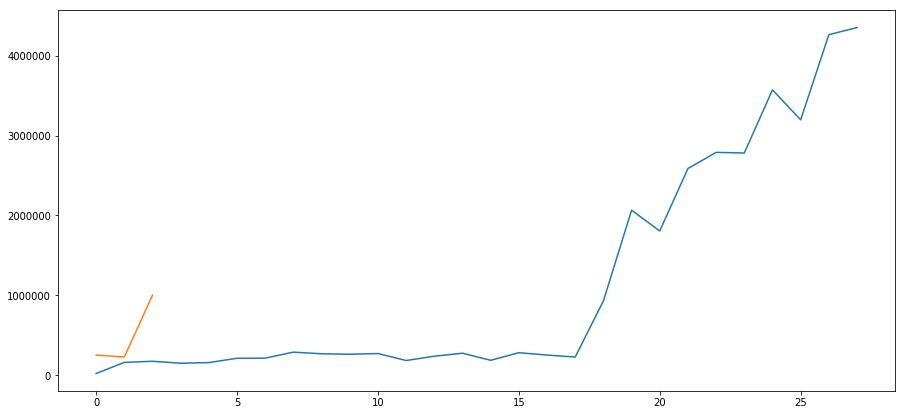

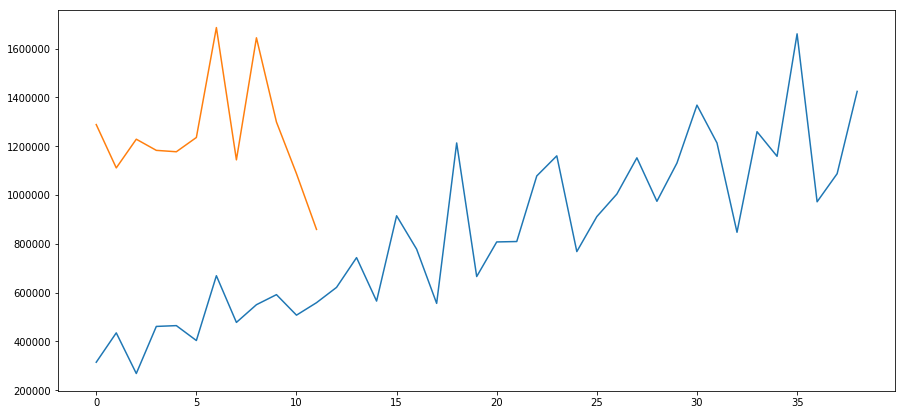

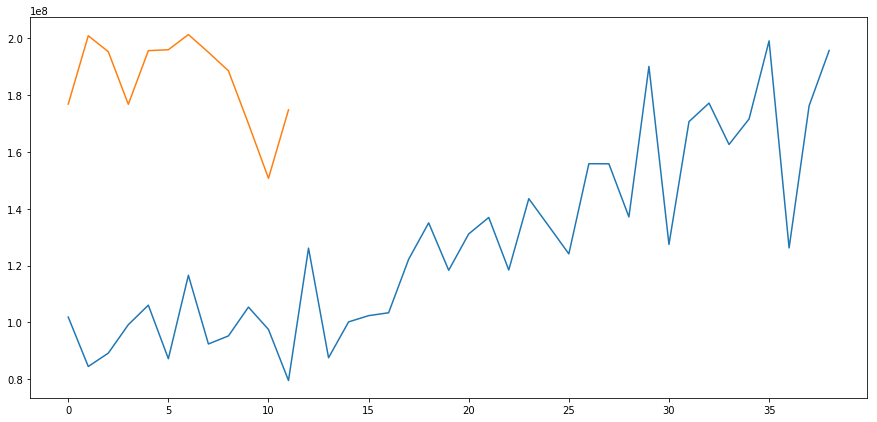

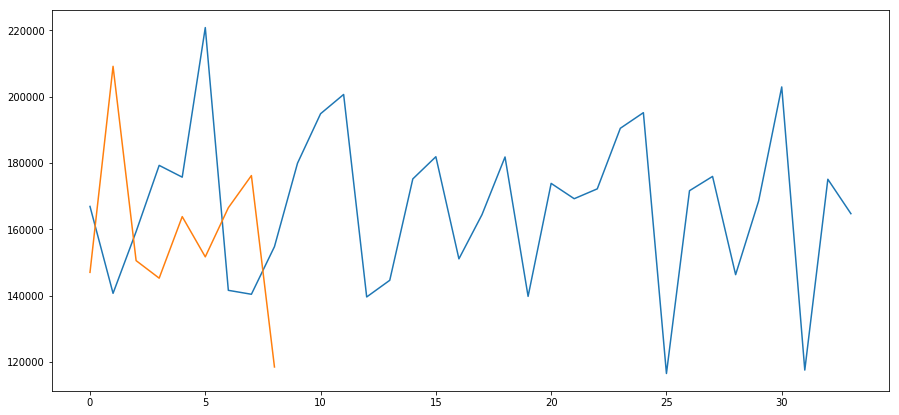

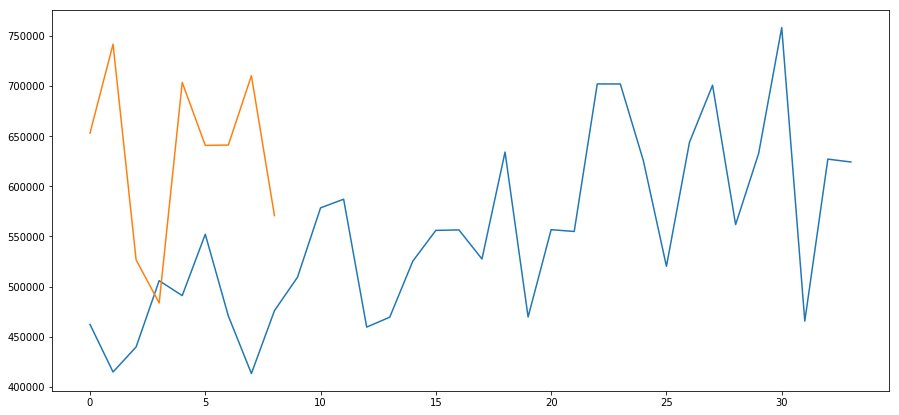

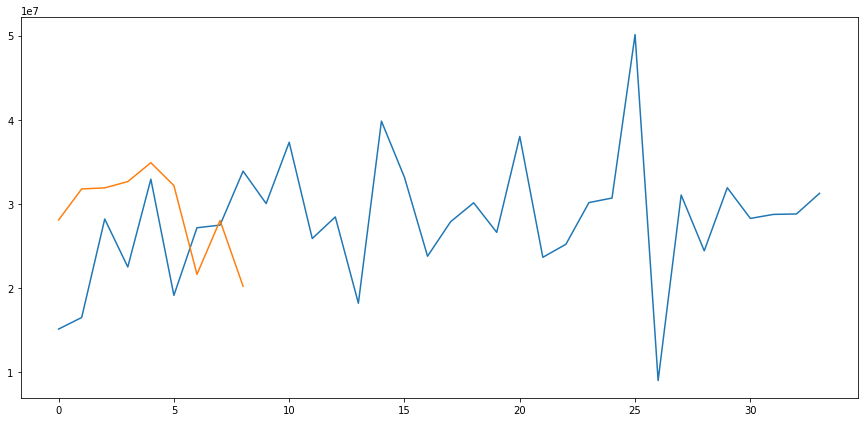

In [38]:
Country = train_df1.Country.unique().tolist()
Product_ID = train_df1.Product_ID.unique().tolist()

for c in Country:
    for p in Product_ID:
        train = train_df1[((train_df1['Country']==c) & (train_df1['Product_ID']==p))].reset_index(drop=True)
        test = test_df1[((test_df1['Country']==c) & (test_df1['Product_ID']==p))].reset_index(drop=True)
        if train.size == 0:
            continue
        train_X = train[['Year', 'Month', 'isHoliday', 'Expense']]
        test_X = test[['Year', 'Month', 'isHoliday', 'Expense']]
#         train_X['Expense_2'] = train_X['Expense']**2
#         test_X['Expense_2'] = test_X['Expense']**2
        train_y = train['Sales']
        plt.figure(figsize=(15, 7))
        plt.plot(train_X.index, train_y)
#         if p==3:
#             train_X.drop(['Expense'], 1, inplace=True)
#             test_X.drop(['Expense'], 1, inplace=True)
#             train_X = train_X[train_X['Year']==2016].reset_index(drop=True)
#             train_y = train_y[-12:]
#             train_X['Days'] = train_X['Month'].map(days)
#             test_X['Days'] = test_X['Month'].map(days)

#             train_X['Days'] = train_X['Days'] - train_df1['isHoliday']
#             test_X['Days'] = test_X['Days'] - test_df1['isHoliday']
            
        pred_test, loss, model, plst = runXGB(train_X, train_y, test_X, rounds=500, feature_names=train_X.columns.tolist())
        print(c, ' ', p)
        print(loss)
        plt.plot(pred_test)
        test['Sales'] = pred_test
        test_df1 = test_df1.merge(test, on=['S_No', 'Year', 'Month', 'Country', 'Product_ID', 'isHoliday', 'Expense'], how='left')

In [39]:
y = ['S_No', 'Year', 'Month', 'Product_ID', 'Country', 'Expense', 'isHoliday']
x = test_df1.columns.tolist()
col = [item for item in x if item not in y]
test_df1['Sales'] = test_df1[col].sum(1)
test_df1 = test_df1[['S_No', 'Year', 'Month', 'Product_ID', 'Country', 'Sales']]

Argentina   1
16.045774450900712
Argentina   2
2.1965097796950683


/home/dj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCo

Argentina   3
6.624686685965593
Columbia   1
1.9606462083829421
Columbia   2
0.26115532837444594
Columbia   3
18.174031635569772
Belgium   2
5.741281034882258
Denmark   2
3.366590467085212
England   4
2.71010651360195
England   5
2.431849111646665
Finland   4
8.963026070273754


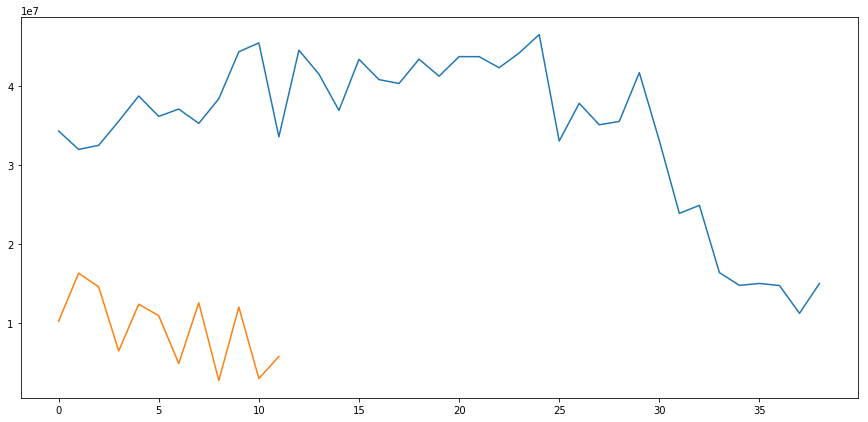

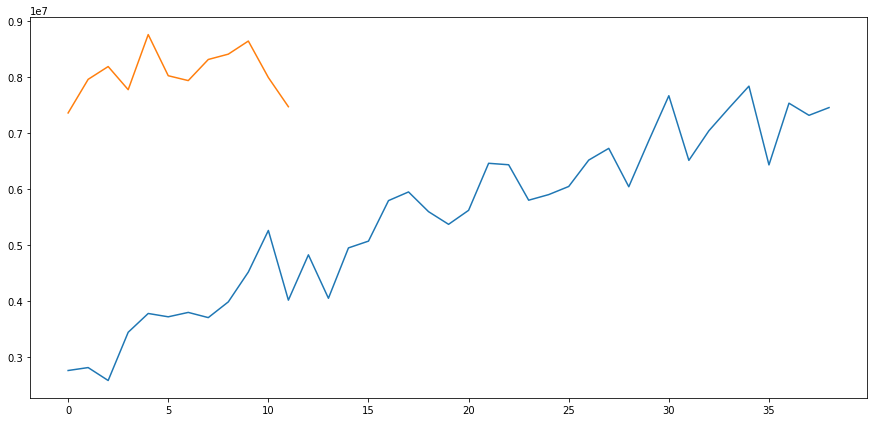

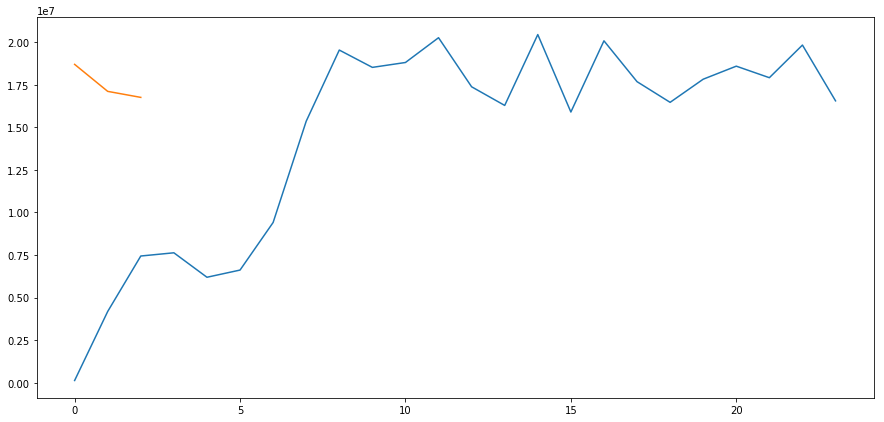

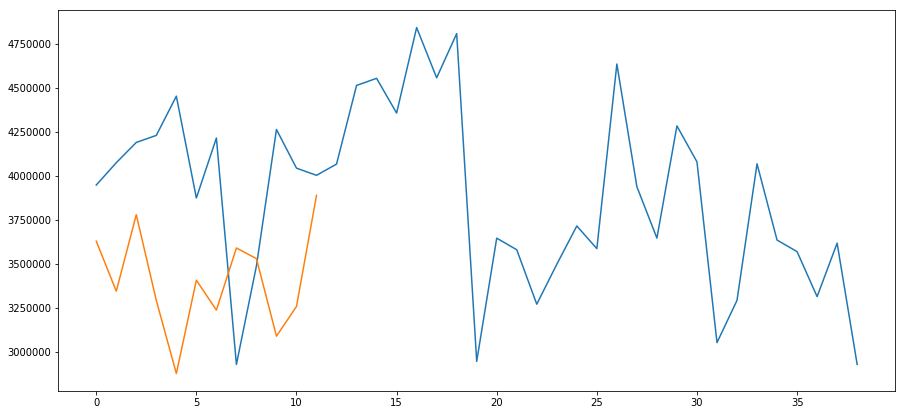

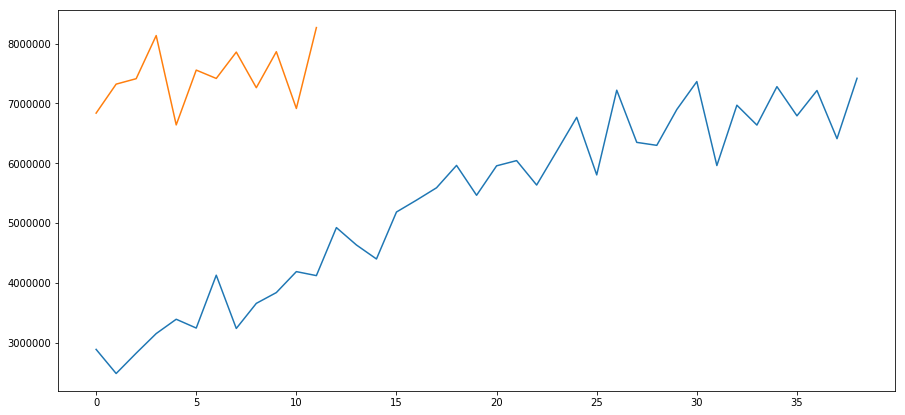

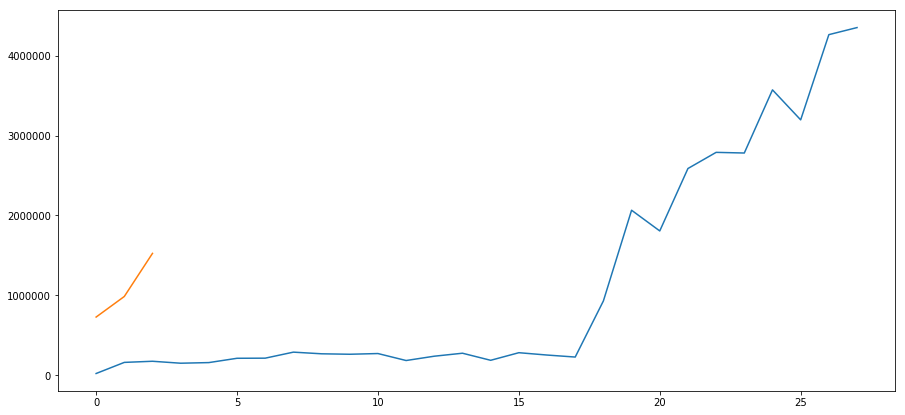

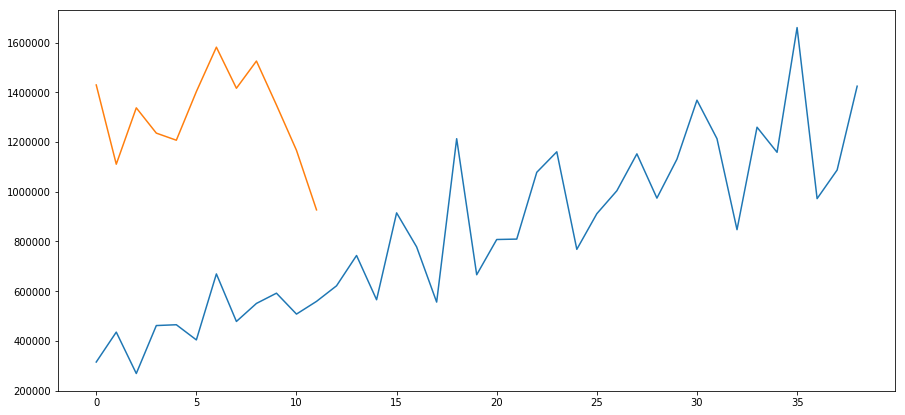

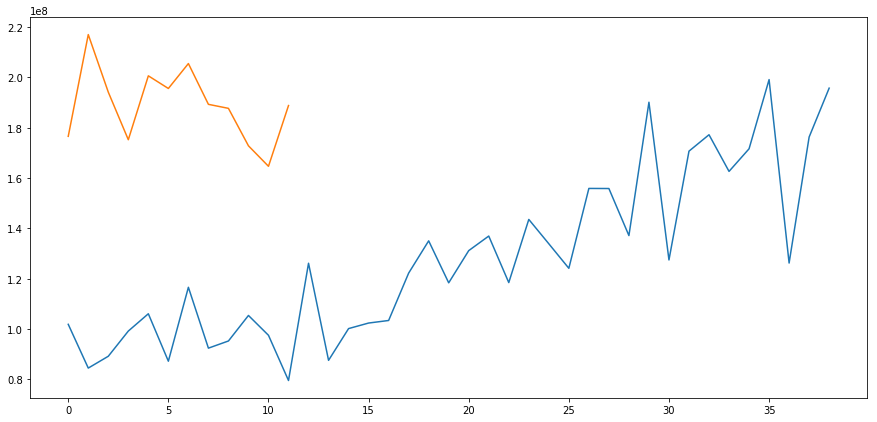

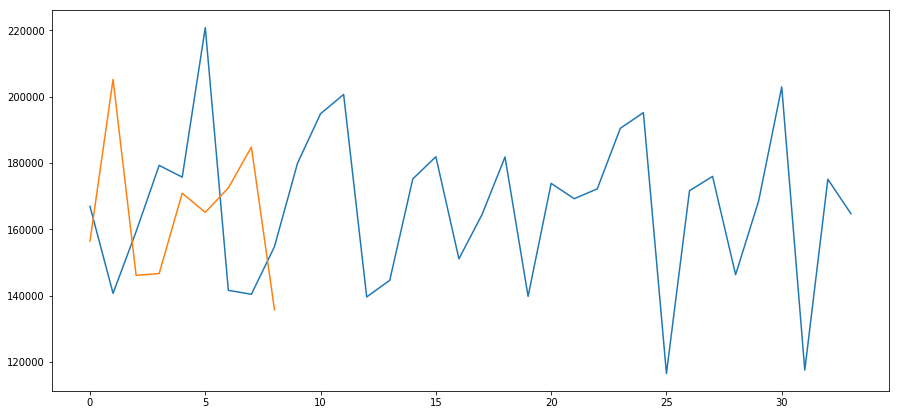

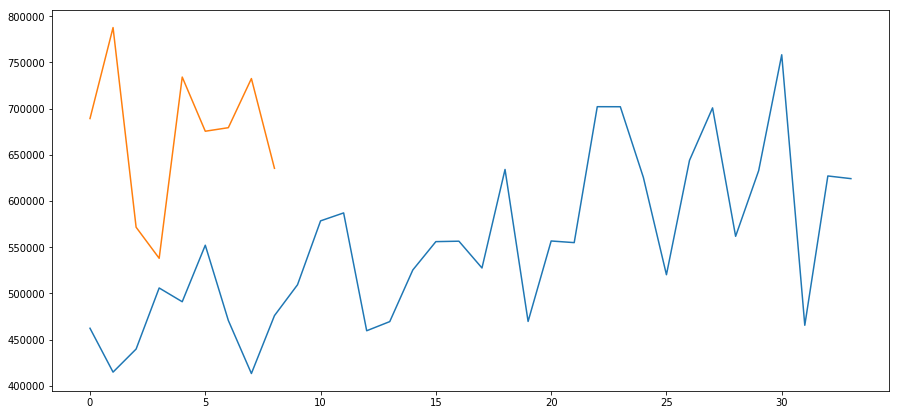

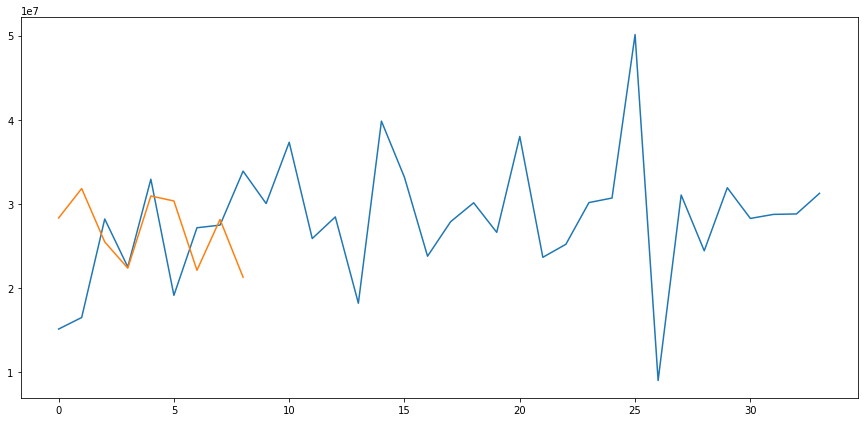

In [40]:
Country = train_df2.Country.unique().tolist()
Product_ID = train_df2.Product_ID.unique().tolist()

for c in Country:
    for p in Product_ID:
        train = train_df2[((train_df2['Country']==c) & (train_df2['Product_ID']==p))].reset_index(drop=True)
        test = test_df2[((test_df2['Country']==c) & (test_df2['Product_ID']==p))].reset_index(drop=True)
        if train.size == 0:
            continue
        train_X = train[['Year', 'Month', 'isHoliday', 'Expense']]
        test_X = test[['Year', 'Month', 'isHoliday', 'Expense']]
#         train_X['Expense_2'] = train_X['Expense']**2
#         test_X['Expense_2'] = test_X['Expense']**2
        train_y = train['Sales']
        plt.figure(figsize=(15, 7))
        plt.plot(train_X.index, train_y)
        if p==3:
            train_X.drop(['Expense'], 1, inplace=True)
            test_X.drop(['Expense'], 1, inplace=True)
            
            train_X = train_X[train_X['Year']==2016].reset_index(drop=True)
            train_y = train_y[-12:]
            train_X['Days'] = train_X['Month'].map(days)
            test_X['Days'] = test_X['Month'].map(days)

            train_X['Days'] = train_X['Days'] - train_df2['isHoliday']
            test_X['Days'] = test_X['Days'] - test_df2['isHoliday']
            
        lr = linear_model.LinearRegression()
        lr.fit(train_X, train_y)
        pred_train_y = lr.predict(train_X)
        loss = symmetric_mean_absolute_percentage_error(train_y, pred_train_y)
        pred_test = lr.predict(test_X)
        print(c, ' ', p)
        print(loss)
        plt.plot(pred_test)
        test['Sales'] = pred_test
        test_df2 = test_df2.merge(test, on=['S_No', 'Year', 'Month', 'Country', 'Product_ID', 'isHoliday', 'Expense'], how='left')

In [41]:
y = ['S_No', 'Year', 'Month', 'Product_ID', 'Country', 'Expense', 'isHoliday']
x = test_df2.columns.tolist()
col = [item for item in x if item not in y]
test_df2['Sales'] = test_df2[col].sum(1)
test_df2 = test_df2[['S_No', 'Year', 'Month', 'Product_ID', 'Country', 'Sales']]

In [42]:
test_df1.head()

,S_No,Year,Month,Product_ID,Country,Sales
0,79073,2016,4,1,Argentina,11342474.0
1,79074,2016,5,1,Argentina,15062276.0
2,79075,2016,6,1,Argentina,15175536.0
3,79076,2016,7,1,Argentina,12283890.0
4,79077,2016,8,1,Argentina,10787184.0


In [43]:
test_df2.head()

,S_No,Year,Month,Product_ID,Country,Sales
0,79073,2016,4,1,Argentina,1.022390e+07
1,79074,2016,5,1,Argentina,1.630606e+07
2,79075,2016,6,1,Argentina,1.457225e+07
3,79076,2016,7,1,Argentina,6.441747e+06
4,79077,2016,8,1,Argentina,1.237197e+07


In [45]:
sales = []

for i in range(len(test_df1)):
    if test_df1['Country'][i] ==  'Argentina' and test_df1['Product_ID'][i] == 1:
        sales.append(test_df1['Sales'][i])
    elif test_df1['Country'][i] ==  'Argentina' and test_df1['Product_ID'][i] == 3:
        sales.append(test_df1['Sales'][i])
    elif test_df1['Country'][i] ==  'Columbia' and test_df1['Product_ID'][i] == 1:
        sales.append(test_df1['Sales'][i])
    elif test_df1['Country'][i] ==  'England' and test_df1['Product_ID'][i] ==4:
        sales.append(test_df1['Sales'][i])
    elif test_df1['Country'][i] ==  'Finland' and test_df1['Product_ID'][i] ==4:
        sales.append(test_df1['Sales'][i])
    else:
        sales.append(test_df2['Sales'][i])

In [51]:
columbia = train_df1[((train_df1['Country']=='Columbia') & (train_df1['Product_ID']==3))].reset_index(drop=True)

In [58]:
temp1 = columbia['Sales'][25]
temp2 = columbia['Sales'][26]
temp3 = columbia['Sales'][27]

mean1 = (temp1+temp2+temp3)/3

temp1 = mean1

mean2 = (temp1+temp2+temp3)/3

temp2 = temp1
temp1 = mean2

mean3 = (temp1+temp2+temp3)/3

In [86]:
sales[63] = mean1
sales[64] = mean2
sales[65] = mean3

In [88]:
test_sub = test_df1.copy()
test_sub['Sales'] = sales

In [90]:
test_sub.to_csv('sub5.csv', index=False)